# Setup

**Utils**

In [ ]:
import gc
import os
import time
import warnings

gc.enable()
warnings.filterwarnings(action='ignore')

**Data analysis**

In [ ]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

**Visualization**

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

**Modeling**

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

**Reproducibility**

In [ ]:
SEED = 2311
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

**Data**

In [ ]:
DATA_URL = 'https://raw.githubusercontent.com/stiwari-ds/data-science-competitions/main/analytics_vidhya/dataverse_hack/data'

train = pd.read_csv(f'{DATA_URL}/raw/train.csv')
test = pd.read_csv(f'{DATA_URL}/raw/test.csv')
sample_sub = pd.read_csv(f'{DATA_URL}/raw/sample_submission.csv')

# Data Overview

In [ ]:
train.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.5159,0.05,0.6442,C1,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.6726,0.02,0.3750,C2,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.8411,0.02,0.3846,C3,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.9003,0.11,0.4327,C4,21622,1,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K12N Dualjet,2,Yes,Yes,No,Yes,Yes,Drum,1197,4,Automatic,5,Electric,4.8,3995,1735,1515,1335,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.5964,0.11,0.6346,C5,34738,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,No,No,No,No,Yes,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


In [ ]:
sample_sub.head()

,policy_id,is_claim
0,ID58593,1
1,ID58594,1
2,ID58595,1
3,ID58596,1
4,ID58597,1


**Datatypes and dimensions**

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  max_torque                        58592 non-null  object 
 11  max_power                         58592 non-null  object 
 12  engi

In [ ]:
train.shape, test.shape, sample_sub.shape

((58592, 44), (39063, 43), (39063, 2))

**Missing values**

In [ ]:
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

No missing values.

**TARGET**

In [ ]:
TARGET = 'is_claim'

In [ ]:
train[TARGET].value_counts()

0    54844
1     3748
Name: is_claim, dtype: int64

In [ ]:
train[TARGET].value_counts(normalize=True)

0    0.936
1    0.064
Name: is_claim, dtype: float64

Highly imbalanced.

# Feature exploration (and preprocessing)

### Utility functions

In [ ]:
def plot_cont(feature):
    """Plot side-by-side kdeplots for train and test
    data distribution of continuous feature.
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20, 4))
    plt.suptitle(f'Feature: {feature}', fontweight='bold')
    sns.kdeplot(x=feature, data=train, ax=ax[0], cut=0)
    ax[0].set_title('Train data')
    ax[0].minorticks_on()
    sns.kdeplot(x=feature, data=test, ax=ax[1], cut=0)
    ax[1].set_title('Test data')
    ax[1].minorticks_on()
    fig.tight_layout()
    plt.show()

In [ ]:
def plot_cont_vs_target(feature):
    """Plot kdeplot for distribution of continuous feature
    split by categories of Target variable.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
    plt.suptitle(f'{feature} vs. {TARGET}', fontweight='bold')
    ax.minorticks_on()
    sns.kdeplot(x=feature, data=train, hue=TARGET, ax=ax, cut=0)
    fig.tight_layout()
    plt.show()

In [ ]:
def explore_cont(feature):
    #Feature distribution 
    describe_df = pd.DataFrame()
    describe_df.index = train[feature].describe().index
    describe_df['Train'] = train[feature].describe().values
    describe_df['Test'] = test[feature].describe().values
    print('\nFeature distribution:')
    display(describe_df.T)
    plot_cont(feature)
    #Feature distribution grouped by target class
    print(f'\nFeature distribution vs target variable:')
    display(train.groupby(TARGET)[feature].describe())
    plot_cont_vs_target(feature)

In [ ]:
def explore_cat(feature):
    #Unique values
    print(f'\nNumber of unique values: ' \
          f'Train - {train[feature].nunique()}, Test - {test[feature].nunique()}')
    print(f'Unique values: ')
    print(f'Train - {pd.unique(train[feature])}')
    print(f'Test - {pd.unique(test[feature])}')
    #Value counts
    print(f'\nNormalized value counts:')
    train_value_counts = train[feature].value_counts(normalize=True, dropna=False).to_frame()
    test_value_counts = test[feature].value_counts(normalize=True, dropna=False).to_frame()
    counts_df = train_value_counts.join(test_value_counts, lsuffix='_Train', rsuffix='_Test')
    display(counts_df.T)
    #Target grouped by feature
    print(f'\nTarget value counts grouped by feature:')
    display(train.groupby(feature)[TARGET].value_counts(normalize=True))

### Unique identifier: policy_id

In [ ]:
train.policy_id.nunique(), train.shape[0]

(58592, 58592)

In [ ]:
test.policy_id.nunique(), test.shape[0]

(39063, 39063)

In [ ]:
set(train.policy_id.unique()).intersection(set(test.policy_id.unique()))

set()

Confirmed as a unique identifier. Should be dropped from feature set before modeling.

### policy_tenure


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,58592.0,0.6112,0.4142,0.0027,0.2102,0.5738,1.0391,1.3966
Test,39063.0,0.6113,0.4150,0.0027,0.2090,0.5741,1.0409,1.3914


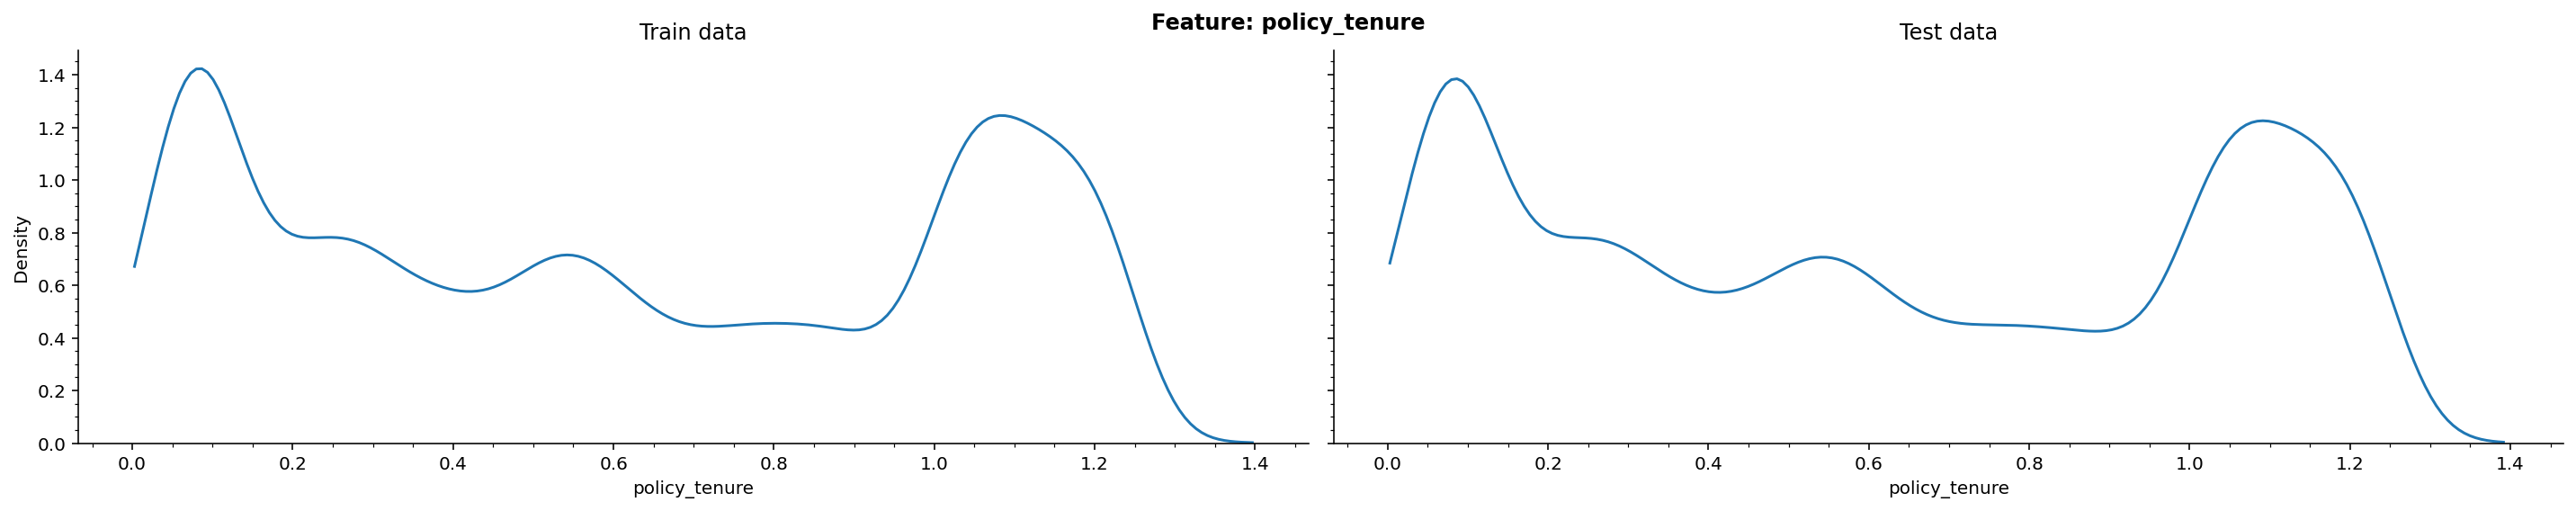


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
is_claim,,,,,,,,
0,54844.0,0.6027,0.4144,0.0027,0.1999,0.5610,1.0356,1.3966
1,3748.0,0.7360,0.3892,0.0029,0.3996,0.8332,1.0841,1.3359


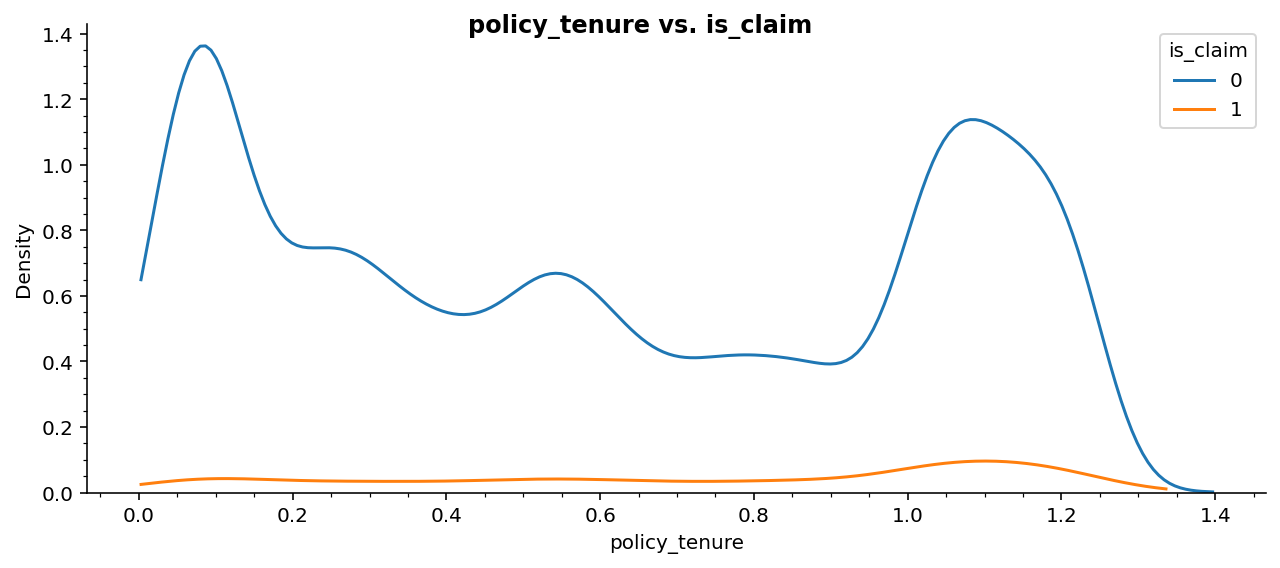

In [ ]:
explore_cont('policy_tenure')

### age_of_car


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,58592.0,0.0694,0.0567,0.0,0.02,0.06,0.11,1.0
Test,39063.0,0.0696,0.0569,0.0,0.02,0.06,0.11,1.0


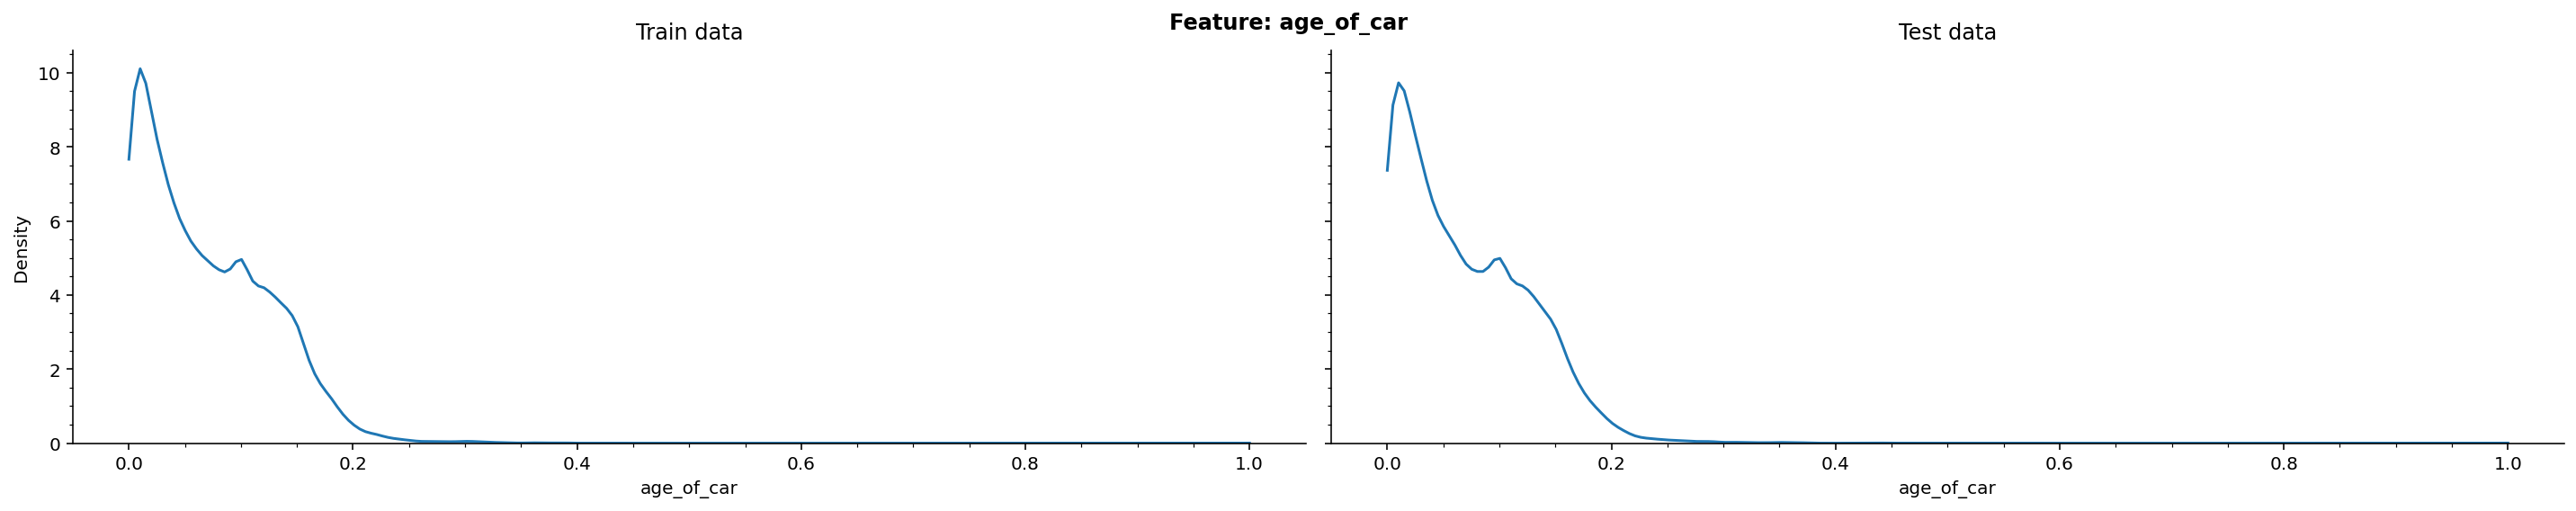


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
is_claim,,,,,,,,
0,54844.0,0.0698,0.0569,0.0,0.02,0.06,0.11,1.00
1,3748.0,0.0633,0.0531,0.0,0.02,0.05,0.10,0.35


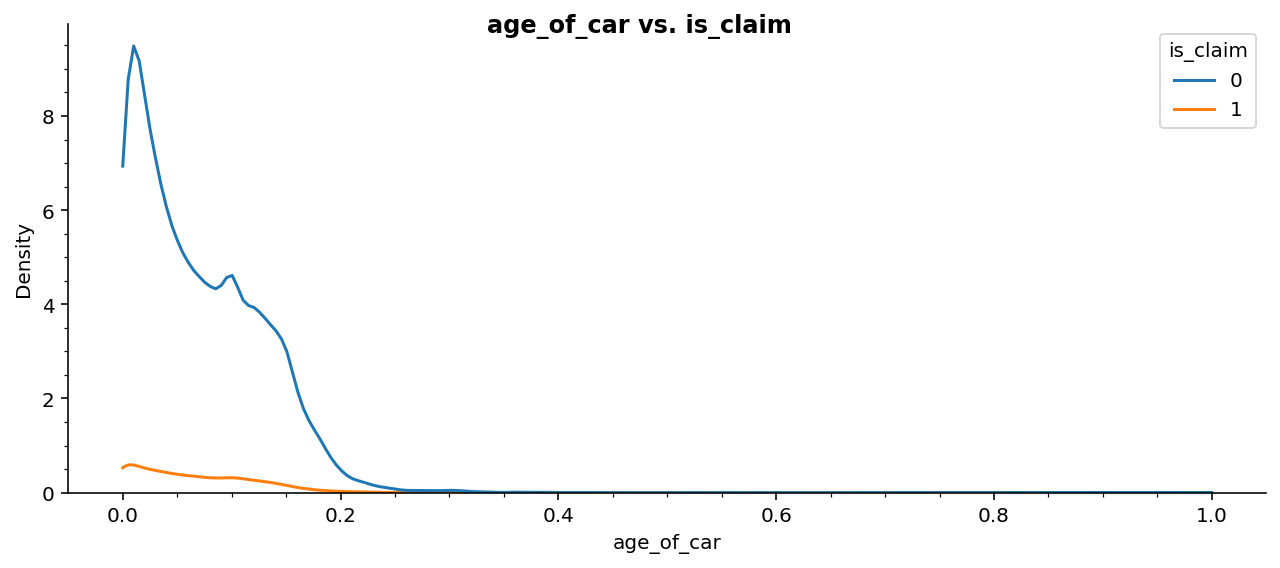

In [ ]:
explore_cont('age_of_car')

### age_of_policyholder


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,58592.0,0.4694,0.1229,0.2885,0.3654,0.4519,0.5481,1.0000
Test,39063.0,0.4691,0.1221,0.2885,0.3750,0.4519,0.5481,0.9904


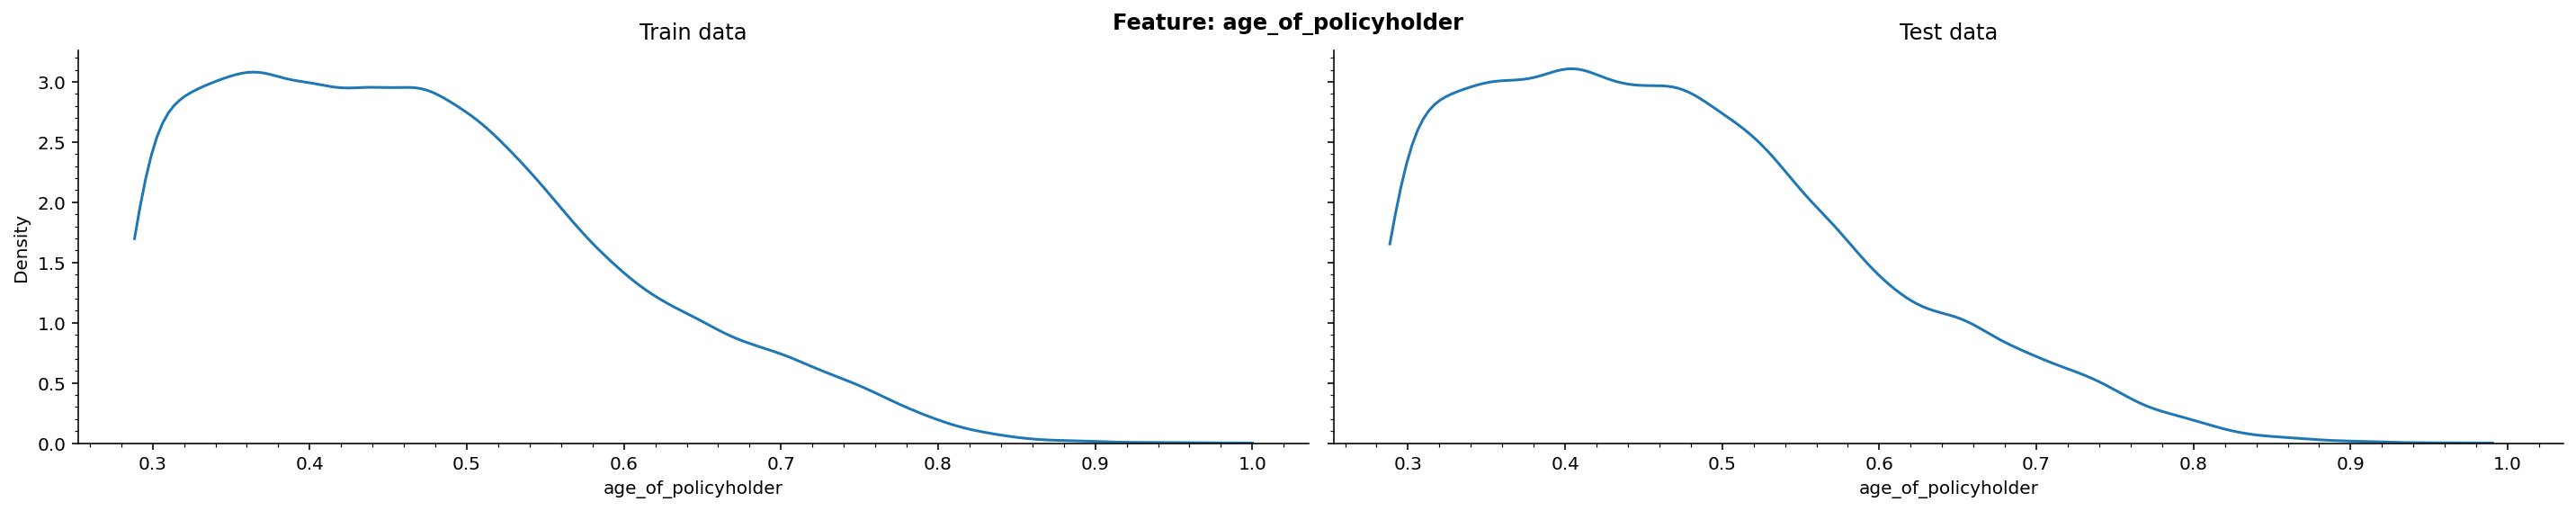


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
is_claim,,,,,,,,
0,54844.0,0.4687,0.1226,0.2885,0.3654,0.4519,0.5481,1.0000
1,3748.0,0.4800,0.1261,0.2885,0.3846,0.4615,0.5577,0.9519


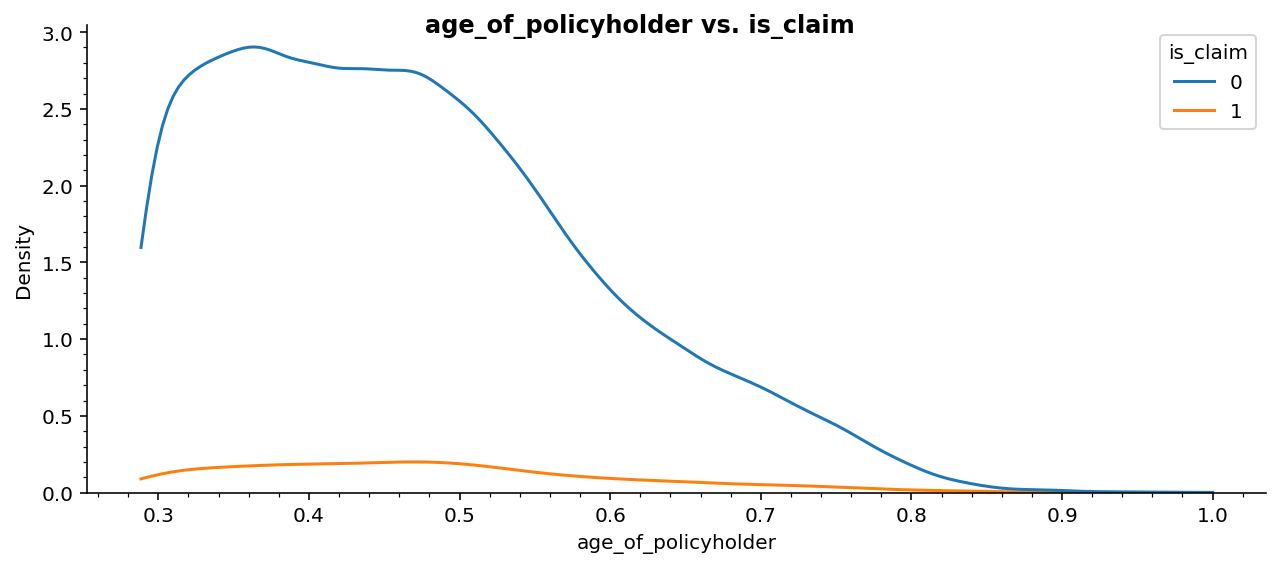

In [ ]:
explore_cont('age_of_policyholder')

### area_cluster

In [ ]:
explore_cat('area_cluster')


Number of unique values: Train - 22, Test - 22
Unique values: 
Train - ['C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8' 'C9' 'C10' 'C11' 'C12' 'C13'
 'C14' 'C15' 'C16' 'C17' 'C18' 'C19' 'C20' 'C21' 'C22']
Test - ['C3' 'C8' 'C5' 'C16' 'C14' 'C11' 'C2' 'C1' 'C9' 'C15' 'C10' 'C19' 'C13'
 'C6' 'C4' 'C12' 'C18' 'C7' 'C22' 'C17' 'C20' 'C21']

Normalized value counts:


,C8,C2,C5,C3,C14,C13,C10,C9,C7,C12,C1,C11,C19,C6,C15,C4,C17,C16,C21,C18,C22,C20
area_cluster_Train,0.2330,0.1253,0.1191,0.1041,0.0625,0.0584,0.0538,0.0467,0.0370,0.0271,0.0251,0.0207,0.0162,0.0152,0.0132,0.0113,0.0084,0.0068,0.0065,0.0041,0.0035,0.0019
area_cluster_Test,0.2345,0.1233,0.1204,0.1042,0.0654,0.0562,0.0542,0.0461,0.0374,0.0273,0.0257,0.0180,0.0161,0.0153,0.0132,0.0114,0.0076,0.0070,0.0069,0.0046,0.0028,0.0022



Target value counts grouped by feature:


area_cluster  is_claim
C1            0           0.9482
              1           0.0518
C10           0           0.9531
              1           0.0469
C11           0           0.9406
              1           0.0594
C12           0           0.9452
              1           0.0548
C13           0           0.9430
              1           0.0570
C14           0           0.9232
              1           0.0768
C15           0           0.9507
              1           0.0493
C16           0           0.9426
              1           0.0574
C17           0           0.9614
              1           0.0386
C18           0           0.8926
              1           0.1074
C19           0           0.9254
              1           0.0746
C2            0           0.9292
              1           0.0708
C20           0           0.9541
              1           0.0459
C21           0           0.9235
              1           0.0765
C22           0           0.9179
              1     

### population_density


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,58592.0,18826.8587,17660.1748,290.0,6112.0,8794.0,27003.0,73430.0
Test,39063.0,18816.2325,17651.9424,290.0,6112.0,8794.0,27003.0,73430.0


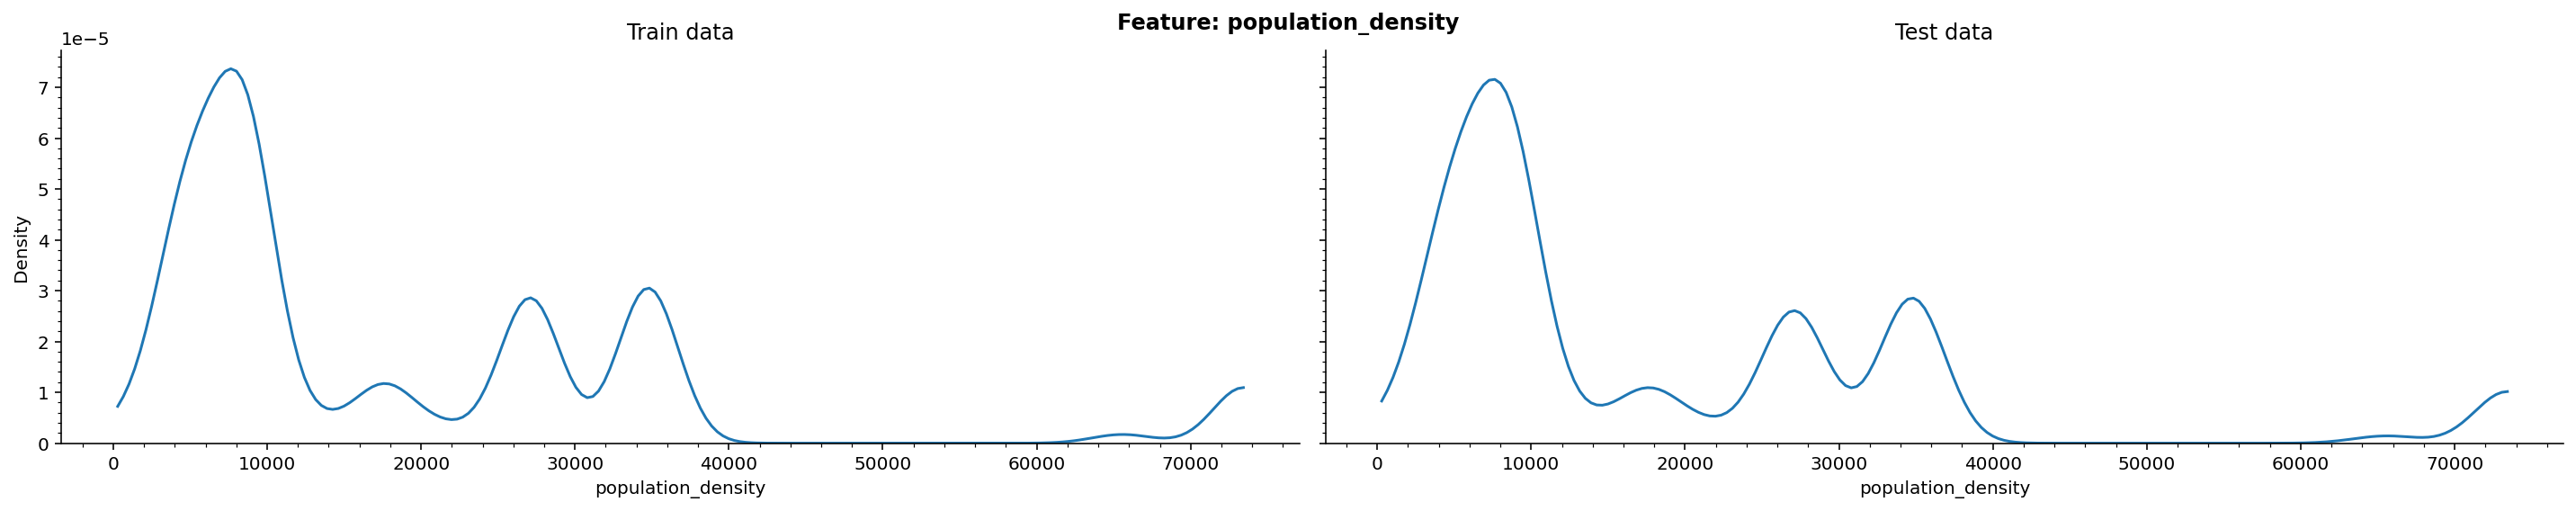


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
is_claim,,,,,,,,
0,54844.0,18909.0734,17757.0862,290.0,6112.0,8794.0,27003.0,73430.0
1,3748.0,17623.8204,16130.1253,290.0,6112.0,8794.0,27003.0,73430.0


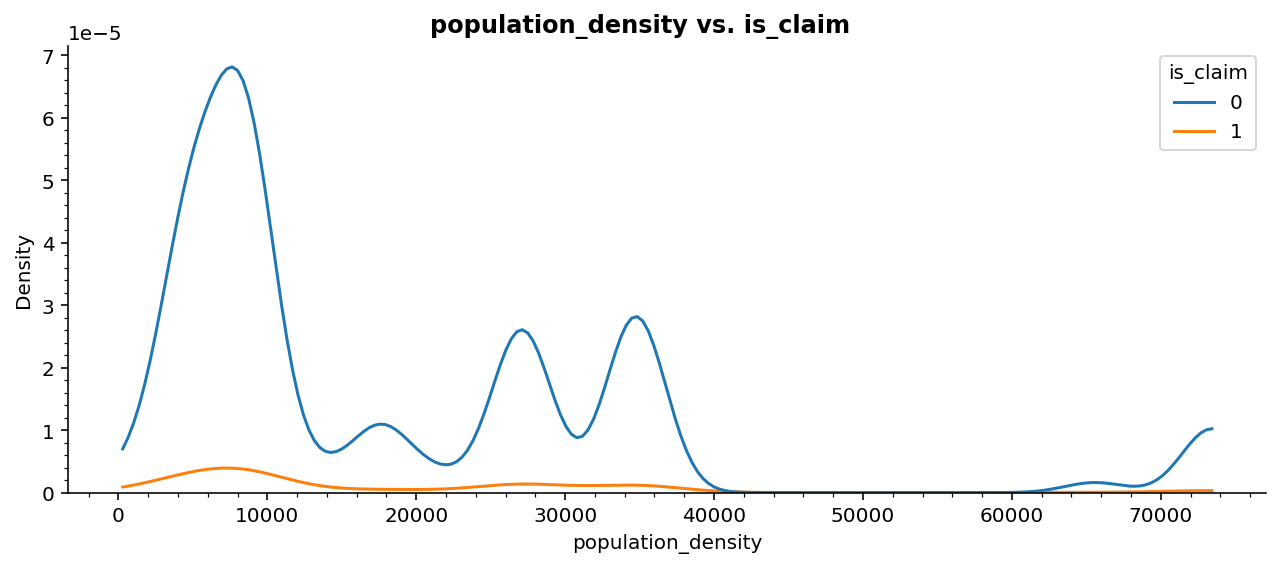

In [ ]:
explore_cont('population_density')

Seems like values are numerical but fixed.

In [ ]:
train.population_density.unique(), test.population_density.unique()

(array([ 4990, 27003,  4076, 21622, 34738, 13051,  6112,  8794, 17804,
        73430,  6108, 34791,  5410,  7788,   290, 16206, 65567, 35036,
        27742, 20905,  3264, 16733]),
 array([ 4076,  8794, 34738, 16206,  7788,  6108, 27003,  4990, 17804,
          290, 73430, 27742,  5410, 13051, 21622, 34791, 35036,  6112,
        16733, 65567, 20905,  3264]))

In [ ]:
train[['area_cluster', 'population_density']].value_counts(normalize=True)

area_cluster  population_density
C8            8794                  0.2330
C2            27003                 0.1253
C5            34738                 0.1191
C3            4076                  0.1041
C14           7788                  0.0625
C13           5410                  0.0584
C10           73430                 0.0538
C9            17804                 0.0467
C7            6112                  0.0370
C12           34791                 0.0271
C1            4990                  0.0251
C11           6108                  0.0207
C19           27742                 0.0162
C6            13051                 0.0152
C15           290                   0.0132
C4            21622                 0.0113
C17           65567                 0.0084
C16           16206                 0.0068
C21           3264                  0.0065
C18           35036                 0.0041
C22           16733                 0.0035
C20           20905                 0.0019
dtype: float64

Fixed population density for each cluster.

In [ ]:
test[['area_cluster', 'population_density']].value_counts(normalize=True)

area_cluster  population_density
C8            8794                  0.2345
C2            27003                 0.1233
C5            34738                 0.1204
C3            4076                  0.1042
C14           7788                  0.0654
C13           5410                  0.0562
C10           73430                 0.0542
C9            17804                 0.0461
C7            6112                  0.0374
C12           34791                 0.0273
C1            4990                  0.0257
C11           6108                  0.0180
C19           27742                 0.0161
C6            13051                 0.0153
C15           290                   0.0132
C4            21622                 0.0114
C17           65567                 0.0076
C16           16206                 0.0070
C21           3264                  0.0069
C18           35036                 0.0046
C22           16733                 0.0028
C20           20905                 0.0022
dtype: float64

### make

In [ ]:
explore_cat('make')


Number of unique values: Train - 5, Test - 5
Unique values: 
Train - [1 2 3 4 5]
Test - [1 2 3 4 5]

Normalized value counts:


,1,3,2,5,4
make_Train,0.6507,0.2392,0.0405,0.0361,0.0335
make_Test,0.6494,0.2397,0.0422,0.0357,0.0330



Target value counts grouped by feature:


make  is_claim
1     0           0.9356
      1           0.0644
2     0           0.9461
      1           0.0539
3     0           0.9357
      1           0.0643
4     0           0.9332
      1           0.0668
5     0           0.9371
      1           0.0629
Name: is_claim, dtype: float64

### segment

In [ ]:
explore_cat('segment')


Number of unique values: Train - 6, Test - 6
Unique values: 
Train - ['A' 'C1' 'C2' 'B2' 'B1' 'Utility']
Test - ['A' 'B2' 'B1' 'C2' 'C1' 'Utility']

Normalized value counts:


,B2,A,C2,B1,C1,Utility
segment_Train,0.3126,0.2956,0.2392,0.0712,0.0607,0.0206
segment_Test,0.3085,0.2993,0.2397,0.0741,0.0599,0.0186



Target value counts grouped by feature:


segment  is_claim
A        0           0.9396
         1           0.0604
B1       0           0.9415
         1           0.0585
B2       0           0.9314
         1           0.0686
C1       0           0.9359
         1           0.0641
C2       0           0.9357
         1           0.0643
Utility  0           0.9396
         1           0.0604
Name: is_claim, dtype: float64

### model

In [ ]:
explore_cat('model')


Number of unique values: Train - 11, Test - 11
Unique values: 
Train - ['M1' 'M2' 'M3' 'M4' 'M5' 'M6' 'M7' 'M8' 'M9' 'M10' 'M11']
Test - ['M1' 'M6' 'M3' 'M7' 'M8' 'M4' 'M5' 'M9' 'M2' 'M11' 'M10']

Normalized value counts:


,M1,M4,M6,M8,M7,M3,M9,M5,M10,M2,M11
model_Train,0.2551,0.2392,0.2351,0.0712,0.0502,0.0405,0.0361,0.0273,0.0206,0.0184,0.0062
model_Test,0.2570,0.2397,0.2317,0.0741,0.0498,0.0422,0.0357,0.0269,0.0186,0.0182,0.0060



Target value counts grouped by feature:


model  is_claim
M1     0           0.9386
       1           0.0614
M10    0           0.9396
       1           0.0604
M11    0           0.9587
       1           0.0413
M2     0           0.9259
       1           0.0741
M3     0           0.9461
       1           0.0539
M4     0           0.9357
       1           0.0643
M5     0           0.9274
       1           0.0726
M6     0           0.9318
       1           0.0682
M7     0           0.9316
       1           0.0684
M8     0           0.9415
       1           0.0585
M9     0           0.9371
       1           0.0629
Name: is_claim, dtype: float64

### fuel_type

In [ ]:
explore_cat('fuel_type')


Number of unique values: Train - 3, Test - 3
Unique values: 
Train - ['CNG' 'Petrol' 'Diesel']
Test - ['CNG' 'Petrol' 'Diesel']

Normalized value counts:


,Petrol,CNG,Diesel
fuel_type_Train,0.3504,0.3470,0.3026
fuel_type_Test,0.3480,0.3497,0.3024



Target value counts grouped by feature:


fuel_type  is_claim
CNG        0           0.9393
           1           0.0607
Diesel     0           0.9351
           1           0.0649
Petrol     0           0.9336
           1           0.0664
Name: is_claim, dtype: float64

### max_torque

In [ ]:
explore_cat('max_torque')


Number of unique values: Train - 9, Test - 9
Unique values: 
Train - ['60Nm@3500rpm' '113Nm@4400rpm' '91Nm@4250rpm' '250Nm@2750rpm'
 '200Nm@3000rpm' '82.1Nm@3400rpm' '200Nm@1750rpm' '85Nm@3000rpm'
 '170Nm@4000rpm']
Test - ['60Nm@3500rpm' '113Nm@4400rpm' '91Nm@4250rpm' '82.1Nm@3400rpm'
 '250Nm@2750rpm' '200Nm@3000rpm' '200Nm@1750rpm' '170Nm@4000rpm'
 '85Nm@3000rpm']

Normalized value counts:


,113Nm@4400rpm,60Nm@3500rpm,250Nm@2750rpm,82.1Nm@3400rpm,91Nm@4250rpm,200Nm@1750rpm,200Nm@3000rpm,85Nm@3000rpm,170Nm@4000rpm
max_torque_Train,0.3037,0.2551,0.2392,0.0712,0.0405,0.0361,0.0273,0.0206,0.0062
max_torque_Test,0.2997,0.2570,0.2397,0.0741,0.0422,0.0357,0.0269,0.0186,0.0060



Target value counts grouped by feature:


max_torque      is_claim
113Nm@4400rpm   0           0.9314
                1           0.0686
170Nm@4000rpm   0           0.9587
                1           0.0413
200Nm@1750rpm   0           0.9371
                1           0.0629
200Nm@3000rpm   0           0.9274
                1           0.0726
250Nm@2750rpm   0           0.9357
                1           0.0643
60Nm@3500rpm    0           0.9386
                1           0.0614
82.1Nm@3400rpm  0           0.9415
                1           0.0585
85Nm@3000rpm    0           0.9396
                1           0.0604
91Nm@4250rpm    0           0.9461
                1           0.0539
Name: is_claim, dtype: float64

### max_power

In [ ]:
explore_cat('max_power')


Number of unique values: Train - 9, Test - 9
Unique values: 
Train - ['40.36bhp@6000rpm' '88.50bhp@6000rpm' '67.06bhp@5500rpm'
 '113.45bhp@4000rpm' '88.77bhp@4000rpm' '55.92bhp@5300rpm'
 '97.89bhp@3600rpm' '61.68bhp@6000rpm' '118.36bhp@5500rpm']
Test - ['40.36bhp@6000rpm' '88.50bhp@6000rpm' '67.06bhp@5500rpm'
 '55.92bhp@5300rpm' '113.45bhp@4000rpm' '88.77bhp@4000rpm'
 '97.89bhp@3600rpm' '118.36bhp@5500rpm' '61.68bhp@6000rpm']

Normalized value counts:


,88.50bhp@6000rpm,40.36bhp@6000rpm,113.45bhp@4000rpm,55.92bhp@5300rpm,67.06bhp@5500rpm,97.89bhp@3600rpm,88.77bhp@4000rpm,61.68bhp@6000rpm,118.36bhp@5500rpm
max_power_Train,0.3037,0.2551,0.2392,0.0712,0.0405,0.0361,0.0273,0.0206,0.0062
max_power_Test,0.2997,0.2570,0.2397,0.0741,0.0422,0.0357,0.0269,0.0186,0.0060



Target value counts grouped by feature:


max_power          is_claim
113.45bhp@4000rpm  0           0.9357
                   1           0.0643
118.36bhp@5500rpm  0           0.9587
                   1           0.0413
40.36bhp@6000rpm   0           0.9386
                   1           0.0614
55.92bhp@5300rpm   0           0.9415
                   1           0.0585
61.68bhp@6000rpm   0           0.9396
                   1           0.0604
67.06bhp@5500rpm   0           0.9461
                   1           0.0539
88.50bhp@6000rpm   0           0.9314
                   1           0.0686
88.77bhp@4000rpm   0           0.9274
                   1           0.0726
97.89bhp@3600rpm   0           0.9371
                   1           0.0629
Name: is_claim, dtype: float64

In [ ]:
train[['max_torque', 'max_power']].value_counts(normalize=True)

max_torque      max_power        
113Nm@4400rpm   88.50bhp@6000rpm     0.3037
60Nm@3500rpm    40.36bhp@6000rpm     0.2551
250Nm@2750rpm   113.45bhp@4000rpm    0.2392
82.1Nm@3400rpm  55.92bhp@5300rpm     0.0712
91Nm@4250rpm    67.06bhp@5500rpm     0.0405
200Nm@1750rpm   97.89bhp@3600rpm     0.0361
200Nm@3000rpm   88.77bhp@4000rpm     0.0273
85Nm@3000rpm    61.68bhp@6000rpm     0.0206
170Nm@4000rpm   118.36bhp@5500rpm    0.0062
dtype: float64

Perfectly correlated values. Only one of these columns is needed.

### engine_type

In [ ]:
explore_cat('engine_type')


Number of unique values: Train - 11, Test - 11
Unique values: 
Train - ['F8D Petrol Engine' '1.2 L K12N Dualjet' '1.0 SCe' '1.5 L U2 CRDi'
 '1.5 Turbocharged Revotorq' 'K Series Dual jet' '1.2 L K Series Engine'
 'K10C' 'i-DTEC' 'G12B' '1.5 Turbocharged Revotron']
Test - ['F8D Petrol Engine' 'K Series Dual jet' '1.0 SCe' '1.2 L K Series Engine'
 'K10C' '1.5 L U2 CRDi' '1.5 Turbocharged Revotorq' 'i-DTEC'
 '1.2 L K12N Dualjet' '1.5 Turbocharged Revotron' 'G12B']

Normalized value counts:


,F8D Petrol Engine,1.5 L U2 CRDi,K Series Dual jet,K10C,1.2 L K Series Engine,1.0 SCe,i-DTEC,1.5 Turbocharged Revotorq,G12B,1.2 L K12N Dualjet,1.5 Turbocharged Revotron
engine_type_Train,0.2551,0.2392,0.2351,0.0712,0.0502,0.0405,0.0361,0.0273,0.0206,0.0184,0.0062
engine_type_Test,0.2570,0.2397,0.2317,0.0741,0.0498,0.0422,0.0357,0.0269,0.0186,0.0182,0.0060



Target value counts grouped by feature:


engine_type                is_claim
1.0 SCe                    0           0.9461
                           1           0.0539
1.2 L K Series Engine      0           0.9316
                           1           0.0684
1.2 L K12N Dualjet         0           0.9259
                           1           0.0741
1.5 L U2 CRDi              0           0.9357
                           1           0.0643
1.5 Turbocharged Revotorq  0           0.9274
                           1           0.0726
1.5 Turbocharged Revotron  0           0.9587
                           1           0.0413
F8D Petrol Engine          0           0.9386
                           1           0.0614
G12B                       0           0.9396
                           1           0.0604
K Series Dual jet          0           0.9318
                           1           0.0682
K10C                       0           0.9415
                           1           0.0585
i-DTEC                     0           0.937

In [ ]:
train[['model', 'engine_type']].value_counts(normalize=True)

model  engine_type              
M1     F8D Petrol Engine            0.2551
M4     1.5 L U2 CRDi                0.2392
M6     K Series Dual jet            0.2351
M8     K10C                         0.0712
M7     1.2 L K Series Engine        0.0502
M3     1.0 SCe                      0.0405
M9     i-DTEC                       0.0361
M5     1.5 Turbocharged Revotorq    0.0273
M10    G12B                         0.0206
M2     1.2 L K12N Dualjet           0.0184
M11    1.5 Turbocharged Revotron    0.0062
dtype: float64

Perfectly correlated values. Only one of these columns is needed.

### airbags

In [ ]:
explore_cat('airbags')


Number of unique values: Train - 3, Test - 3
Unique values: 
Train - [2 6 1]
Test - [2 6 1]

Normalized value counts:


,2,6,1
airbags_Train,0.6899,0.2894,0.0206
airbags_Test,0.6919,0.2896,0.0186



Target value counts grouped by feature:


airbags  is_claim
1        0           0.9396
         1           0.0604
2        0           0.9364
         1           0.0636
6        0           0.9350
         1           0.0650
Name: is_claim, dtype: float64

Numerical but only three unique values. Can be treated as categorical too.

### rear_brakes_type

In [ ]:
explore_cat('rear_brakes_type')


Number of unique values: Train - 2, Test - 2
Unique values: 
Train - ['Drum' 'Disc']
Test - ['Drum' 'Disc']

Normalized value counts:


,Drum,Disc
rear_brakes_type_Train,0.7608,0.2392
rear_brakes_type_Test,0.7603,0.2397



Target value counts grouped by feature:


rear_brakes_type  is_claim
Disc              0           0.9357
                  1           0.0643
Drum              0           0.9361
                  1           0.0639
Name: is_claim, dtype: float64

### displacement


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,58592.0,1162.3559,266.3048,796.0,796.0,1197.0,1493.0,1498.0
Test,39063.0,1160.6058,266.9428,796.0,796.0,1197.0,1493.0,1498.0


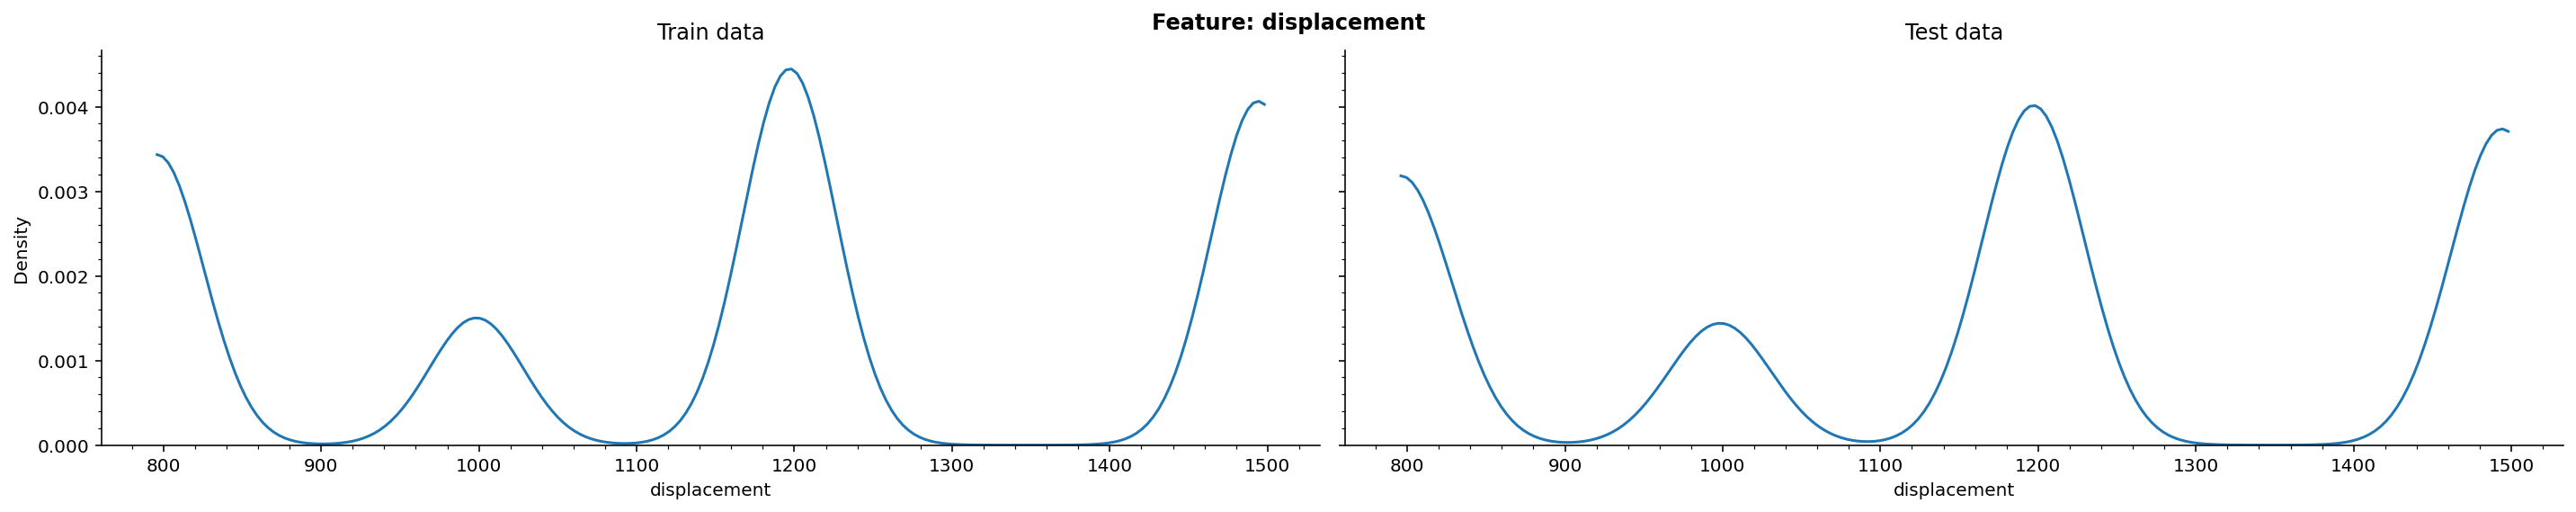


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
is_claim,,,,,,,,
0,54844.0,1161.8213,266.4597,796.0,796.0,1197.0,1493.0,1498.0
1,3748.0,1170.1772,263.9397,796.0,998.0,1197.0,1493.0,1498.0


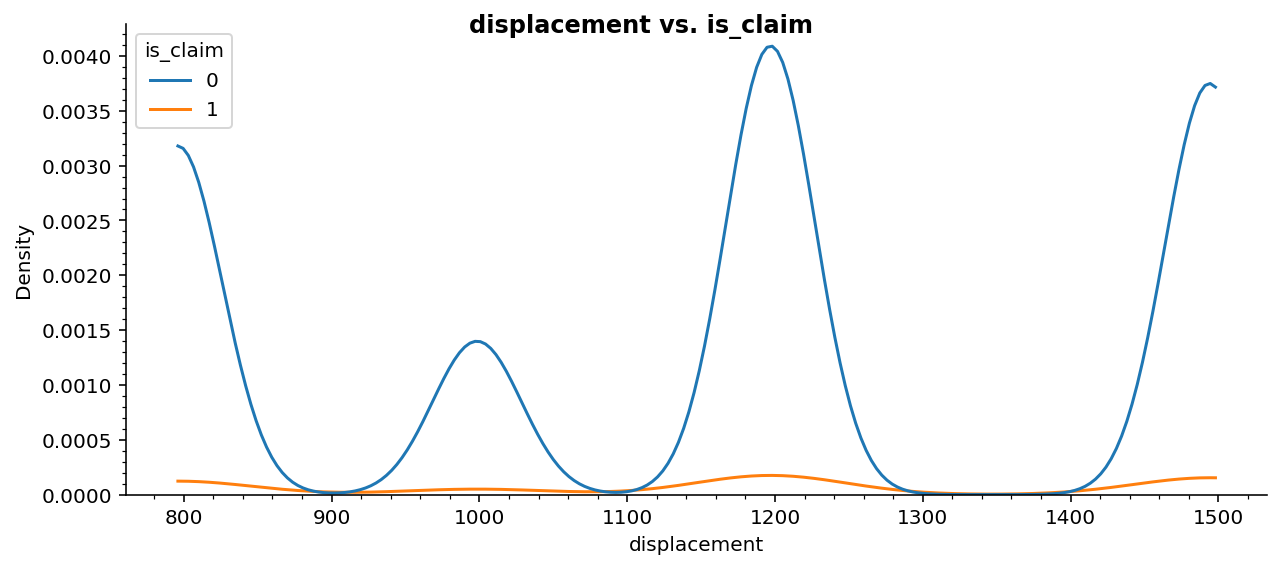

In [ ]:
explore_cont('displacement')

Numerical but values are fixed.

In [ ]:
explore_cat('displacement')


Number of unique values: Train - 9, Test - 9
Unique values: 
Train - [ 796 1197  999 1493 1497  998 1498 1196 1199]
Test - [ 796 1197  999  998 1493 1497 1498 1199 1196]

Normalized value counts:


,1197,796,1493,998,999,1498,1497,1196,1199
displacement_Train,0.3037,0.2551,0.2392,0.0712,0.0405,0.0361,0.0273,0.0206,0.0062
displacement_Test,0.2997,0.2570,0.2397,0.0741,0.0422,0.0357,0.0269,0.0186,0.0060



Target value counts grouped by feature:


displacement  is_claim
796           0           0.9386
              1           0.0614
998           0           0.9415
              1           0.0585
999           0           0.9461
              1           0.0539
1196          0           0.9396
              1           0.0604
1197          0           0.9314
              1           0.0686
1199          0           0.9587
              1           0.0413
1493          0           0.9357
              1           0.0643
1497          0           0.9274
              1           0.0726
1498          0           0.9371
              1           0.0629
Name: is_claim, dtype: float64

In [ ]:
train[['max_torque', 'max_power', 'displacement']].value_counts(normalize=True)

max_torque      max_power          displacement
113Nm@4400rpm   88.50bhp@6000rpm   1197            0.3037
60Nm@3500rpm    40.36bhp@6000rpm   796             0.2551
250Nm@2750rpm   113.45bhp@4000rpm  1493            0.2392
82.1Nm@3400rpm  55.92bhp@5300rpm   998             0.0712
91Nm@4250rpm    67.06bhp@5500rpm   999             0.0405
200Nm@1750rpm   97.89bhp@3600rpm   1498            0.0361
200Nm@3000rpm   88.77bhp@4000rpm   1497            0.0273
85Nm@3000rpm    61.68bhp@6000rpm   1196            0.0206
170Nm@4000rpm   118.36bhp@5500rpm  1199            0.0062
dtype: float64

Perfectly correlated values for these three columns. Only one of them should be needed.

### cylinder

In [ ]:
explore_cat('cylinder')


Number of unique values: Train - 2, Test - 2
Unique values: 
Train - [3 4]
Test - [3 4]

Normalized value counts:


,4,3
cylinder_Train,0.6270,0.3730
cylinder_Test,0.6206,0.3794



Target value counts grouped by feature:


cylinder  is_claim
3         0           0.9403
          1           0.0597
4         0           0.9335
          1           0.0665
Name: is_claim, dtype: float64

Numerical but only two discrete values. Can be treated as binary categorical feature too.

### transmission_type

In [ ]:
explore_cat('transmission_type')


Number of unique values: Train - 2, Test - 2
Unique values: 
Train - ['Manual' 'Automatic']
Test - ['Manual' 'Automatic']

Normalized value counts:


,Manual,Automatic
transmission_type_Train,0.6516,0.3484
transmission_type_Test,0.6500,0.3500



Target value counts grouped by feature:


transmission_type  is_claim
Automatic          0           0.9358
                   1           0.0642
Manual             0           0.9361
                   1           0.0639
Name: is_claim, dtype: float64

### gear_box

In [ ]:
explore_cat('gear_box')


Number of unique values: Train - 2, Test - 2
Unique values: 
Train - [5 6]
Test - [5 6]

Normalized value counts:


,5,6
gear_box_Train,0.7546,0.2454
gear_box_Test,0.7542,0.2458



Target value counts grouped by feature:


gear_box  is_claim
5         0           0.9359
          1           0.0641
6         0           0.9363
          1           0.0637
Name: is_claim, dtype: float64

In [ ]:
train[['transmission_type', 'gear_box', 'cylinder']].value_counts(normalize=True)

transmission_type  gear_box  cylinder
Manual             5         3           0.3263
                             4           0.3191
Automatic          6         4           0.2392
                   5         4           0.0686
                             3           0.0405
Manual             6         3           0.0062
dtype: float64

Only a limited number of combinations. But not perfectly correlated.

### steering_type

In [ ]:
explore_cat('steering_type')


Number of unique values: Train - 3, Test - 3
Unique values: 
Train - ['Power' 'Electric' 'Manual']
Test - ['Power' 'Electric' 'Manual']

Normalized value counts:


,Power,Electric,Manual
steering_type_Train,0.5718,0.4076,0.0206
steering_type_Test,0.5769,0.4046,0.0186



Target value counts grouped by feature:


steering_type  is_claim
Electric       0           0.9331
               1           0.0669
Manual         0           0.9396
               1           0.0604
Power          0           0.9380
               1           0.0620
Name: is_claim, dtype: float64

In [ ]:
train[['steering_type', 'is_adjustable_steering']].value_counts(normalize=True)

steering_type  is_adjustable_steering
Electric       Yes                       0.3671
Power          No                        0.3325
               Yes                       0.2392
Electric       No                        0.0405
Manual         No                        0.0206
dtype: float64

Not redundant.

### turning_radius


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,58592.0,4.8529,0.2281,4.5,4.6,4.8,5.0,5.2
Test,39063.0,4.8532,0.2281,4.5,4.6,4.8,5.0,5.2


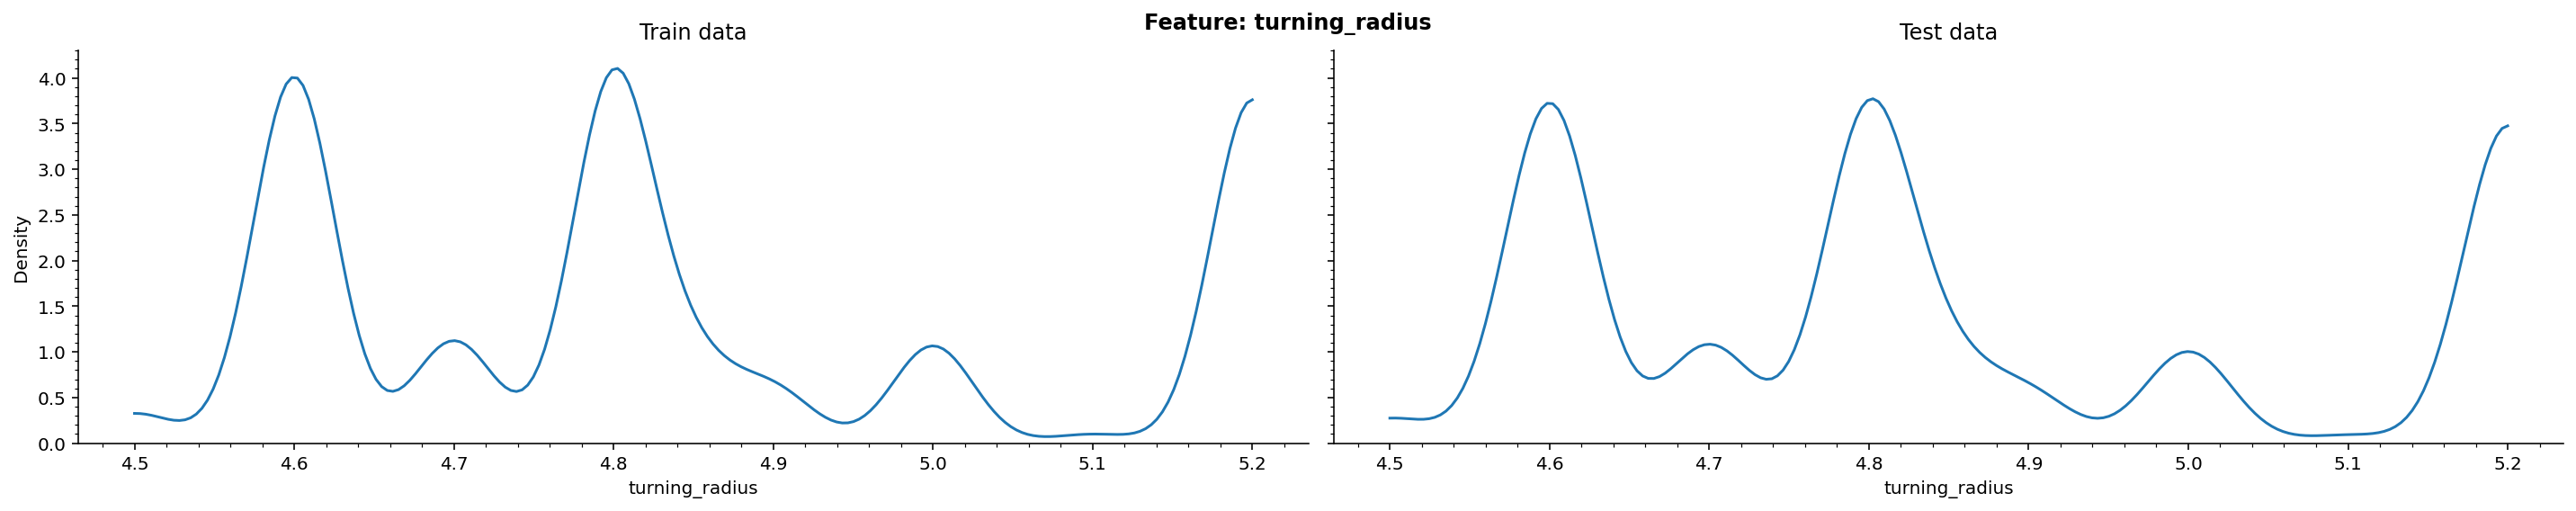


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
is_claim,,,,,,,,
0,54844.0,4.8527,0.2282,4.5,4.6,4.8,5.0,5.2
1,3748.0,4.8553,0.2260,4.5,4.6,4.8,5.0,5.2


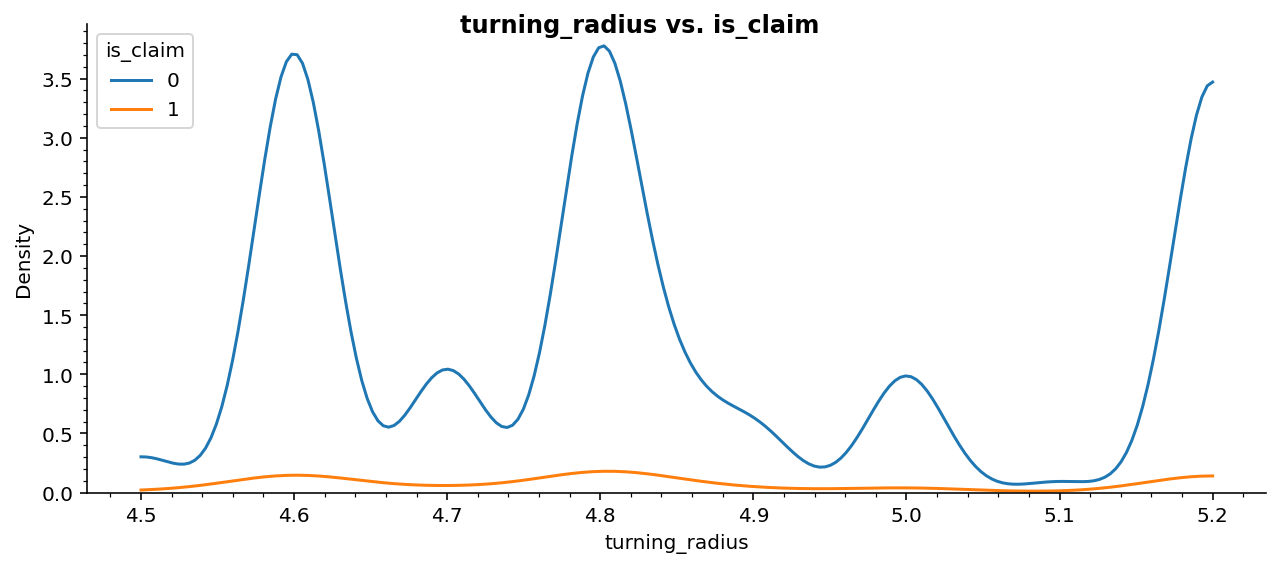

In [ ]:
explore_cont('turning_radius')

In [ ]:
explore_cat('turning_radius')


Number of unique values: Train - 9, Test - 9
Unique values: 
Train - [4.6  4.8  5.   5.2  4.85 4.7  4.9  4.5  5.1 ]
Test - [4.6  4.8  5.   4.85 4.7  5.2  4.9  5.1  4.5 ]

Normalized value counts:


,4.60,4.80,5.20,4.70,5.00,4.85,4.90,4.50,5.10
turning_radius_Train,0.2551,0.2535,0.2392,0.0712,0.0678,0.0502,0.0361,0.0206,0.0062
turning_radius_Test,0.2570,0.2499,0.2397,0.0741,0.0692,0.0498,0.0357,0.0186,0.0060



Target value counts grouped by feature:


turning_radius  is_claim
4.50            0           0.9396
                1           0.0604
4.60            0           0.9386
                1           0.0614
4.70            0           0.9415
                1           0.0585
4.80            0           0.9314
                1           0.0686
4.85            0           0.9316
                1           0.0684
4.90            0           0.9371
                1           0.0629
5.00            0           0.9386
                1           0.0614
5.10            0           0.9587
                1           0.0413
5.20            0           0.9357
                1           0.0643
Name: is_claim, dtype: float64

In [ ]:
train[['max_torque', 'turning_radius']].value_counts()

max_torque      turning_radius
60Nm@3500rpm    4.60              14948
113Nm@4400rpm   4.80              14856
250Nm@2750rpm   5.20              14018
82.1Nm@3400rpm  4.70               4173
113Nm@4400rpm   4.85               2940
91Nm@4250rpm    5.00               2373
200Nm@1750rpm   4.90               2114
200Nm@3000rpm   5.00               1598
85Nm@3000rpm    4.50               1209
170Nm@4000rpm   5.10                363
dtype: int64

Redundant.

### length


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,58592.0,3850.4769,311.4571,3445.0,3445.0,3845.0,3995.0,4300.0
Test,39063.0,3849.3290,312.1812,3445.0,3445.0,3845.0,3995.0,4300.0


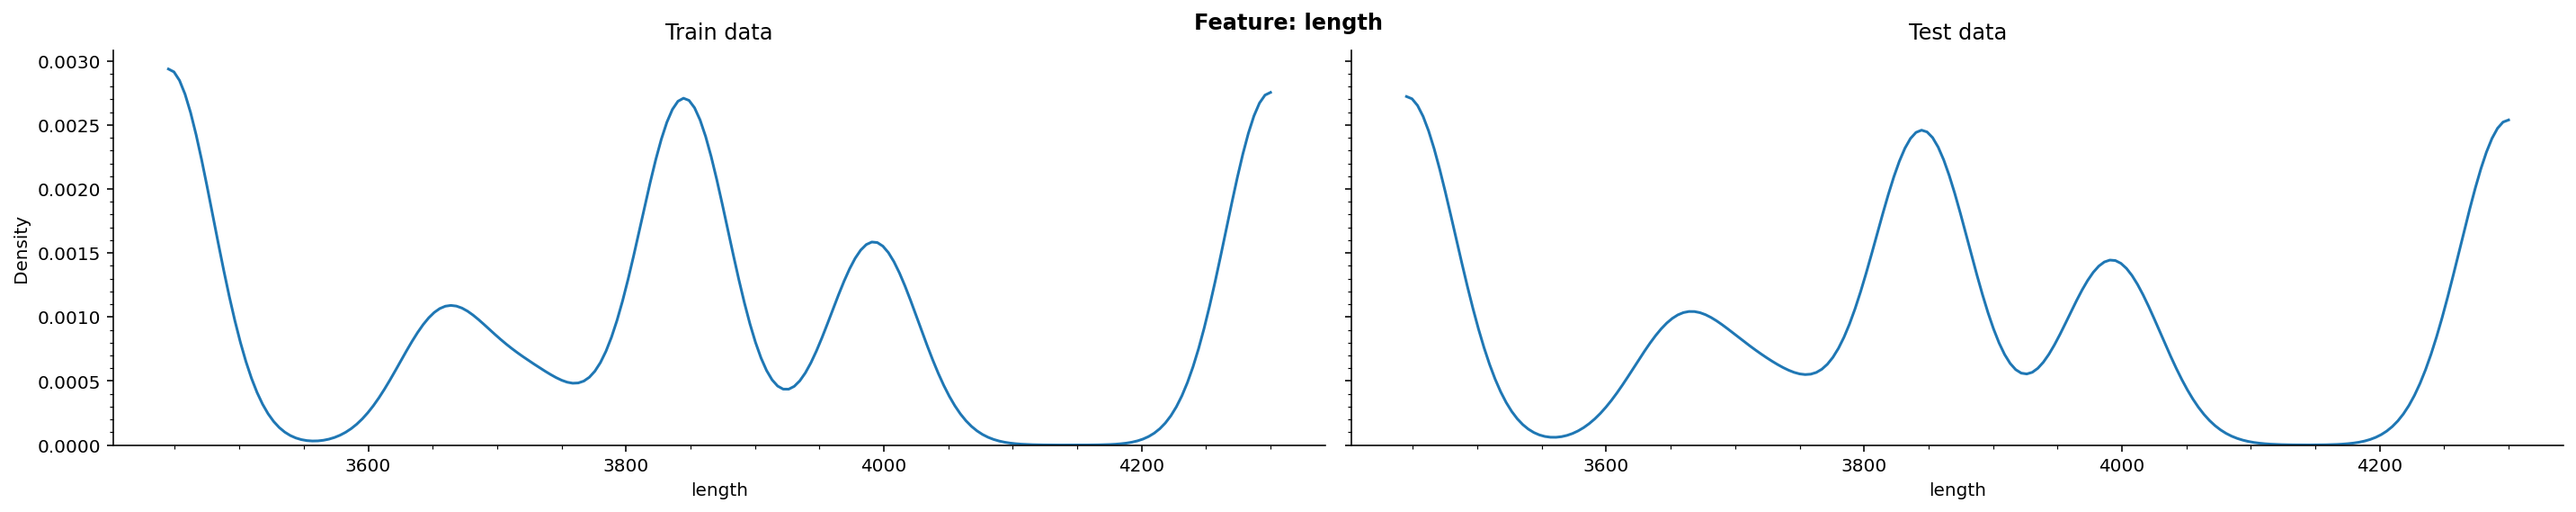


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
is_claim,,,,,,,,
0,54844.0,3849.9481,311.6390,3445.0,3445.0,3845.0,3995.0,4300.0
1,3748.0,3858.2145,308.7215,3445.0,3655.0,3845.0,3995.0,4300.0


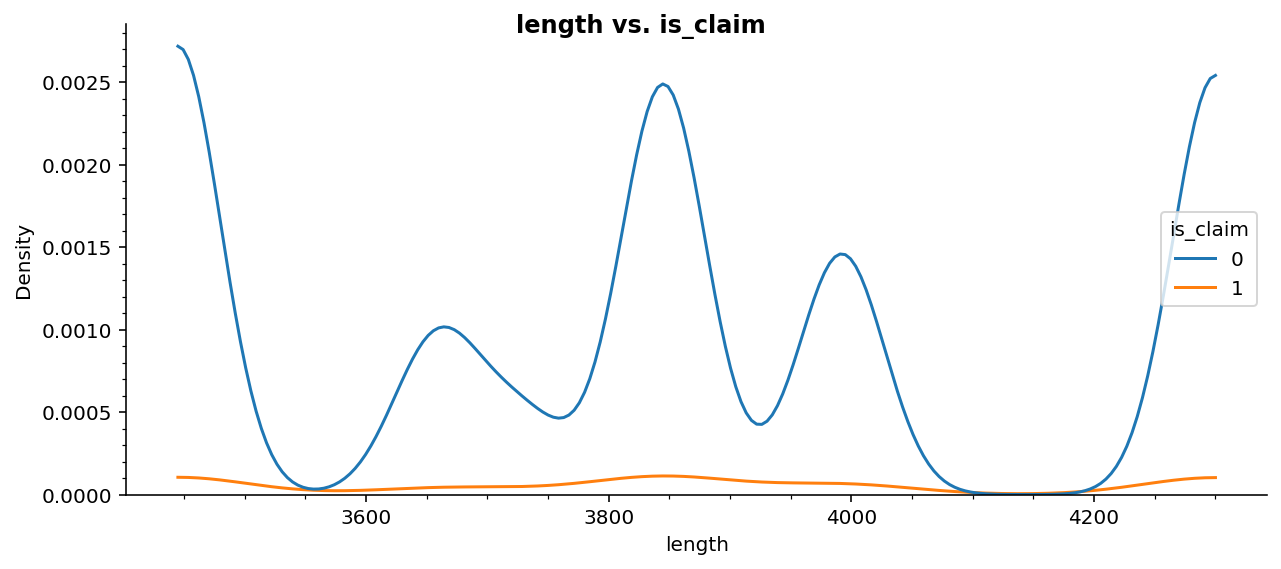

In [ ]:
explore_cont('length')

In [ ]:
explore_cat('length')


Number of unique values: Train - 9, Test - 9
Unique values: 
Train - [3445 3995 3731 4300 3990 3845 3655 3675 3993]
Test - [3445 3845 3731 3990 3655 4300 3995 3993 3675]

Normalized value counts:


,3445,4300,3845,3990,3655,3995,3731,3675,3993
length_Train,0.2551,0.2392,0.2351,0.0775,0.0712,0.0545,0.0405,0.0206,0.0062
length_Test,0.2570,0.2397,0.2317,0.0767,0.0741,0.0539,0.0422,0.0186,0.0060



Target value counts grouped by feature:


length  is_claim
3445    0           0.9386
        1           0.0614
3655    0           0.9415
        1           0.0585
3675    0           0.9396
        1           0.0604
3731    0           0.9461
        1           0.0539
3845    0           0.9318
        1           0.0682
3990    0           0.9301
        1           0.0699
3993    0           0.9587
        1           0.0413
3995    0           0.9333
        1           0.0667
4300    0           0.9357
        1           0.0643
Name: is_claim, dtype: float64

In [ ]:
train[['max_torque', 'length']].value_counts()

max_torque      length
60Nm@3500rpm    3445      14948
250Nm@2750rpm   4300      14018
113Nm@4400rpm   3845      13776
82.1Nm@3400rpm  3655       4173
113Nm@4400rpm   3990       2940
91Nm@4250rpm    3731       2373
200Nm@1750rpm   3995       2114
200Nm@3000rpm   3990       1598
85Nm@3000rpm    3675       1209
113Nm@4400rpm   3995       1080
170Nm@4000rpm   3993        363
dtype: int64

Redundant.

### width

In [ ]:
explore_cat('width')


Number of unique values: Train - 10, Test - 10
Unique values: 
Train - [1515 1735 1579 1790 1755 1745 1620 1695 1475 1811]
Test - [1515 1735 1579 1745 1620 1790 1755 1695 1811 1475]

Normalized value counts:


,1515,1735,1790,1620,1745,1579,1695,1755,1475,1811
width_Train,0.2551,0.2535,0.2392,0.0712,0.0502,0.0405,0.0361,0.0273,0.0206,0.0062
width_Test,0.2570,0.2499,0.2397,0.0741,0.0498,0.0422,0.0357,0.0269,0.0186,0.0060



Target value counts grouped by feature:


width  is_claim
1475   0           0.9396
       1           0.0604
1515   0           0.9386
       1           0.0614
1579   0           0.9461
       1           0.0539
1620   0           0.9415
       1           0.0585
1695   0           0.9371
       1           0.0629
1735   0           0.9314
       1           0.0686
1745   0           0.9316
       1           0.0684
1755   0           0.9274
       1           0.0726
1790   0           0.9357
       1           0.0643
1811   0           0.9587
       1           0.0413
Name: is_claim, dtype: float64

In [ ]:
train[['max_torque', 'width']].value_counts()

max_torque      width
60Nm@3500rpm    1515     14948
113Nm@4400rpm   1735     14856
250Nm@2750rpm   1790     14018
82.1Nm@3400rpm  1620      4173
113Nm@4400rpm   1745      2940
91Nm@4250rpm    1579      2373
200Nm@1750rpm   1695      2114
200Nm@3000rpm   1755      1598
85Nm@3000rpm    1475      1209
170Nm@4000rpm   1811       363
dtype: int64

Only 113Nm@4400 rpm has two associated values, which are both extremely close (10 mm difference). We can consider it to be the same value making this another redundant feature.

### height

In [ ]:
explore_cat('height')


Number of unique values: Train - 11, Test - 11
Unique values: 
Train - [1475 1515 1490 1635 1523 1530 1500 1675 1501 1825 1606]
Test - [1475 1530 1490 1500 1675 1635 1523 1501 1515 1606 1825]

Normalized value counts:


,1475,1635,1530,1675,1500,1490,1501,1523,1825,1515,1606
height_Train,0.2551,0.2392,0.2351,0.0712,0.0502,0.0405,0.0361,0.0273,0.0206,0.0184,0.0062
height_Test,0.2570,0.2397,0.2317,0.0741,0.0498,0.0422,0.0357,0.0269,0.0186,0.0182,0.0060



Target value counts grouped by feature:


height  is_claim
1475    0           0.9386
        1           0.0614
1490    0           0.9461
        1           0.0539
1500    0           0.9316
        1           0.0684
1501    0           0.9371
        1           0.0629
1515    0           0.9259
        1           0.0741
1523    0           0.9274
        1           0.0726
1530    0           0.9318
        1           0.0682
1606    0           0.9587
        1           0.0413
1635    0           0.9357
        1           0.0643
1675    0           0.9415
        1           0.0585
1825    0           0.9396
        1           0.0604
Name: is_claim, dtype: float64

In [ ]:
train[['model', 'height']].value_counts()

model  height
M1     1475      14948
M4     1635      14018
M6     1530      13776
M8     1675       4173
M7     1500       2940
M3     1490       2373
M9     1501       2114
M5     1523       1598
M10    1825       1209
M2     1515       1080
M11    1606        363
dtype: int64

Redundant.

### gross_weight

In [ ]:
explore_cat('gross_weight')


Number of unique values: Train - 10, Test - 10
Unique values: 
Train - [1185 1335 1155 1720 1490 1410 1340 1051 1510 1660]
Test - [1185 1335 1155 1410 1340 1720 1490 1051 1660 1510]

Normalized value counts:


,1185,1335,1720,1340,1410,1155,1051,1490,1510,1660
gross_weight_Train,0.2551,0.2535,0.2392,0.0712,0.0502,0.0405,0.0361,0.0273,0.0206,0.0062
gross_weight_Test,0.2570,0.2499,0.2397,0.0741,0.0498,0.0422,0.0357,0.0269,0.0186,0.0060



Target value counts grouped by feature:


gross_weight  is_claim
1051          0           0.9371
              1           0.0629
1155          0           0.9461
              1           0.0539
1185          0           0.9386
              1           0.0614
1335          0           0.9314
              1           0.0686
1340          0           0.9415
              1           0.0585
1410          0           0.9316
              1           0.0684
1490          0           0.9274
              1           0.0726
1510          0           0.9396
              1           0.0604
1660          0           0.9587
              1           0.0413
1720          0           0.9357
              1           0.0643
Name: is_claim, dtype: float64

In [ ]:
train[['model', 'gross_weight']].value_counts()

model  gross_weight
M1     1185            14948
M4     1720            14018
M6     1335            13776
M8     1340             4173
M7     1410             2940
M3     1155             2373
M9     1051             2114
M5     1490             1598
M10    1510             1209
M2     1335             1080
M11    1660              363
dtype: int64

### Redundancy in car features

In [ ]:
train[['make', 'segment']].value_counts(sort=False)

make  segment
1     A          14948
      B1          4173
      B2         16716
      C1          1080
      Utility     1209
2     A           2373
3     C2         14018
4     B2          1598
      C1           363
5     C1          2114
dtype: int64

Cross distribution of segments in make. Not redundant.

In [ ]:
train[['make', 'model']].value_counts(sort=False)

make  model
1     M1       14948
      M10       1209
      M2        1080
      M6       13776
      M7        2940
      M8        4173
2     M3        2373
3     M4       14018
4     M11        363
      M5        1598
5     M9        2114
dtype: int64

Non-overlapping models in each make (Category and sub-category).  
Therefore, make is redundant.

In [ ]:
train[['model', 'engine_type', 'max_torque', 'max_power', 'displacement', 'turning_radius', 'length', 'width', 'height', 'gross_weight']].value_counts(sort=False, normalize=True)

model  engine_type                max_torque      max_power          displacement  turning_radius  length  width  height  gross_weight
M1     F8D Petrol Engine          60Nm@3500rpm    40.36bhp@6000rpm   796           4.60            3445    1515   1475    1185            0.2551
M10    G12B                       85Nm@3000rpm    61.68bhp@6000rpm   1196          4.50            3675    1475   1825    1510            0.0206
M11    1.5 Turbocharged Revotron  170Nm@4000rpm   118.36bhp@5500rpm  1199          5.10            3993    1811   1606    1660            0.0062
M2     1.2 L K12N Dualjet         113Nm@4400rpm   88.50bhp@6000rpm   1197          4.80            3995    1735   1515    1335            0.0184
M3     1.0 SCe                    91Nm@4250rpm    67.06bhp@5500rpm   999           5.00            3731    1579   1490    1155            0.0405
M4     1.5 L U2 CRDi              250Nm@2750rpm   113.45bhp@4000rpm  1493          5.20            4300    1790   1635    1720            0.

* M2, M6 and M7 have somewhat similar features. But each model has only 1 set of unique features. 
* Therefore, model should be enough to capture all car-related features.
* The numerical features can still be used to find splits, but engine_type, max_power and max_torque have no usefulness.

### ncap_rating

In [ ]:
explore_cat('ncap_rating')


Number of unique values: Train - 5, Test - 5
Unique values: 
Train - [0 2 3 5 4]
Test - [0 2 3 5 4]

Normalized value counts:


,2,0,3,4,5
ncap_rating_Train,0.3653,0.3259,0.2392,0.0361,0.0335
ncap_rating_Test,0.3662,0.3254,0.2397,0.0357,0.0330



Target value counts grouped by feature:


ncap_rating  is_claim
0            0           0.9376
             1           0.0624
2            0           0.9350
             1           0.0650
3            0           0.9357
             1           0.0643
4            0           0.9371
             1           0.0629
5            0           0.9332
             1           0.0668
Name: is_claim, dtype: float64

### Boolean features

In [ ]:
bool_features = ['is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
                 'is_parking_camera', 'is_front_fog_lights','is_rear_window_wiper', 
                 'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist', 
                 'is_power_door_locks', 'is_central_locking', 'is_power_steering',
                 'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
                 'is_ecw', 'is_speed_alert']

In [ ]:
for col in bool_features:
    print('-' * 50)
    print(f'\nFeature: {col}')
    explore_cat(col)

--------------------------------------------------

Feature: is_esc

Number of unique values: Train - 2, Test - 2
Unique values: 
Train - ['No' 'Yes']
Test - ['No' 'Yes']

Normalized value counts:


,No,Yes
is_esc_Train,0.6859,0.3141
is_esc_Test,0.6862,0.3138



Target value counts grouped by feature:


is_esc  is_claim
No      0           0.9365
        1           0.0635
Yes     0           0.9349
        1           0.0651
Name: is_claim, dtype: float64

--------------------------------------------------

Feature: is_adjustable_steering

Number of unique values: Train - 2, Test - 2
Unique values: 
Train - ['No' 'Yes']
Test - ['No' 'Yes']

Normalized value counts:


,Yes,No
is_adjustable_steering_Train,0.6063,0.3937
is_adjustable_steering_Test,0.6021,0.3979



Target value counts grouped by feature:


is_adjustable_steering  is_claim
No                      0           0.9403
                        1           0.0597
Yes                     0           0.9333
                        1           0.0667
Name: is_claim, dtype: float64

--------------------------------------------------

Feature: is_tpms

Number of unique values: Train - 2, Test - 2
Unique values: 
Train - ['No' 'Yes']
Test - ['No' 'Yes']

Normalized value counts:


,No,Yes
is_tpms_Train,0.7608,0.2392
is_tpms_Test,0.7603,0.2397



Target value counts grouped by feature:


is_tpms  is_claim
No       0           0.9361
         1           0.0639
Yes      0           0.9357
         1           0.0643
Name: is_claim, dtype: float64

--------------------------------------------------

Feature: is_parking_sensors

Number of unique values: Train - 2, Test - 2
Unique values: 
Train - ['Yes' 'No']
Test - ['Yes' 'No']

Normalized value counts:


,Yes,No
is_parking_sensors_Train,0.9595,0.0405
is_parking_sensors_Test,0.9578,0.0422



Target value counts grouped by feature:


is_parking_sensors  is_claim
No                  0           0.9461
                    1           0.0539
Yes                 0           0.9356
                    1           0.0644
Name: is_claim, dtype: float64

--------------------------------------------------

Feature: is_parking_camera

Number of unique values: Train - 2, Test - 2
Unique values: 
Train - ['No' 'Yes']
Test - ['No' 'Yes']

Normalized value counts:


,No,Yes
is_parking_camera_Train,0.6094,0.3906
is_parking_camera_Test,0.6083,0.3917



Target value counts grouped by feature:


is_parking_camera  is_claim
No                 0           0.9359
                   1           0.0641
Yes                0           0.9363
                   1           0.0637
Name: is_claim, dtype: float64

--------------------------------------------------

Feature: is_front_fog_lights

Number of unique values: Train - 2, Test - 2
Unique values: 
Train - ['No' 'Yes']
Test - ['No' 'Yes']

Normalized value counts:


,Yes,No
is_front_fog_lights_Train,0.5791,0.4209
is_front_fog_lights_Test,0.5751,0.4249



Target value counts grouped by feature:


is_front_fog_lights  is_claim
No                   0           0.9394
                     1           0.0606
Yes                  0           0.9336
                     1           0.0664
Name: is_claim, dtype: float64

--------------------------------------------------

Feature: is_rear_window_wiper

Number of unique values: Train - 2, Test - 2
Unique values: 
Train - ['No' 'Yes']
Test - ['No' 'Yes']

Normalized value counts:


,No,Yes
is_rear_window_wiper_Train,0.7106,0.2894
is_rear_window_wiper_Test,0.7104,0.2896



Target value counts grouped by feature:


is_rear_window_wiper  is_claim
No                    0           0.9364
                      1           0.0636
Yes                   0           0.9350
                      1           0.0650
Name: is_claim, dtype: float64

--------------------------------------------------

Feature: is_rear_window_washer

Number of unique values: Train - 2, Test - 2
Unique values: 
Train - ['No' 'Yes']
Test - ['No' 'Yes']

Normalized value counts:


,No,Yes
is_rear_window_washer_Train,0.7106,0.2894
is_rear_window_washer_Test,0.7104,0.2896



Target value counts grouped by feature:


is_rear_window_washer  is_claim
No                     0           0.9364
                       1           0.0636
Yes                    0           0.9350
                       1           0.0650
Name: is_claim, dtype: float64

--------------------------------------------------

Feature: is_rear_window_defogger

Number of unique values: Train - 2, Test - 2
Unique values: 
Train - ['No' 'Yes']
Test - ['No' 'Yes']

Normalized value counts:


,No,Yes
is_rear_window_defogger_Train,0.6499,0.3501
is_rear_window_defogger_Test,0.6505,0.3495



Target value counts grouped by feature:


is_rear_window_defogger  is_claim
No                       0           0.9365
                         1           0.0635
Yes                      0           0.9352
                         1           0.0648
Name: is_claim, dtype: float64

--------------------------------------------------

Feature: is_brake_assist

Number of unique values: Train - 2, Test - 2
Unique values: 
Train - ['No' 'Yes']
Test - ['No' 'Yes']

Normalized value counts:


,Yes,No
is_brake_assist_Train,0.5492,0.4508
is_brake_assist_Test,0.5455,0.4545



Target value counts grouped by feature:


is_brake_assist  is_claim
No               0           0.9390
                 1           0.0610
Yes              0           0.9336
                 1           0.0664
Name: is_claim, dtype: float64

--------------------------------------------------

Feature: is_power_door_locks

Number of unique values: Train - 2, Test - 2
Unique values: 
Train - ['No' 'Yes']
Test - ['No' 'Yes']

Normalized value counts:


,Yes,No
is_power_door_locks_Train,0.7242,0.2758
is_power_door_locks_Test,0.7244,0.2756



Target value counts grouped by feature:


is_power_door_locks  is_claim
No                   0           0.9387
                     1           0.0613
Yes                  0           0.9350
                     1           0.0650
Name: is_claim, dtype: float64

--------------------------------------------------

Feature: is_central_locking

Number of unique values: Train - 2, Test - 2
Unique values: 
Train - ['No' 'Yes']
Test - ['No' 'Yes']

Normalized value counts:


,Yes,No
is_central_locking_Train,0.7242,0.2758
is_central_locking_Test,0.7244,0.2756



Target value counts grouped by feature:


is_central_locking  is_claim
No                  0           0.9387
                    1           0.0613
Yes                 0           0.9350
                    1           0.0650
Name: is_claim, dtype: float64

--------------------------------------------------

Feature: is_power_steering

Number of unique values: Train - 2, Test - 2
Unique values: 
Train - ['Yes' 'No']
Test - ['Yes' 'No']

Normalized value counts:


,Yes,No
is_power_steering_Train,0.9794,0.0206
is_power_steering_Test,0.9814,0.0186



Target value counts grouped by feature:


is_power_steering  is_claim
No                 0           0.9396
                   1           0.0604
Yes                0           0.9360
                   1           0.0640
Name: is_claim, dtype: float64

--------------------------------------------------

Feature: is_driver_seat_height_adjustable

Number of unique values: Train - 2, Test - 2
Unique values: 
Train - ['No' 'Yes']
Test - ['No' 'Yes']

Normalized value counts:


,Yes,No
is_driver_seat_height_adjustable_Train,0.5853,0.4147
is_driver_seat_height_adjustable_Test,0.5812,0.4188



Target value counts grouped by feature:


is_driver_seat_height_adjustable  is_claim
No                                0           0.9391
                                  1           0.0609
Yes                               0           0.9338
                                  1           0.0662
Name: is_claim, dtype: float64

--------------------------------------------------

Feature: is_day_night_rear_view_mirror

Number of unique values: Train - 2, Test - 2
Unique values: 
Train - ['No' 'Yes']
Test - ['No' 'Yes']

Normalized value counts:


,No,Yes
is_day_night_rear_view_mirror_Train,0.6197,0.3803
is_day_night_rear_view_mirror_Test,0.6224,0.3776



Target value counts grouped by feature:


is_day_night_rear_view_mirror  is_claim
No                             0           0.9376
                               1           0.0624
Yes                            0           0.9335
                               1           0.0665
Name: is_claim, dtype: float64

--------------------------------------------------

Feature: is_ecw

Number of unique values: Train - 2, Test - 2
Unique values: 
Train - ['No' 'Yes']
Test - ['No' 'Yes']

Normalized value counts:


,Yes,No
is_ecw_Train,0.7242,0.2758
is_ecw_Test,0.7244,0.2756



Target value counts grouped by feature:


is_ecw  is_claim
No      0           0.9387
        1           0.0613
Yes     0           0.9350
        1           0.0650
Name: is_claim, dtype: float64

--------------------------------------------------

Feature: is_speed_alert

Number of unique values: Train - 2, Test - 2
Unique values: 
Train - ['Yes' 'No']
Test - ['Yes' 'No']

Normalized value counts:


,Yes,No
is_speed_alert_Train,0.9938,0.0062
is_speed_alert_Test,0.9940,0.0060



Target value counts grouped by feature:


is_speed_alert  is_claim
No              0           0.9587
                1           0.0413
Yes             0           0.9359
                1           0.0641
Name: is_claim, dtype: float64

* No notable splits for target variable.
* is_power_steering and is_speed_alert are highly imbalanced resulting in low variance for boolean feature.

# Preprocessing

In [ ]:
#drop redundant features
redundant_features = ['policy_id', 'make', 'max_torque', 'max_power', 'engine_type']
features = [f for f in test.columns if f not in redundant_features]

In [ ]:
onehot_features = ['area_cluster', 'model', 'segment', 'fuel_type', 'steering_type']

In [ ]:
train['area_cluster'] = train['area_cluster'].apply(lambda x: x[1:]).astype('category')
test['area_cluster'] = test['area_cluster'].apply(lambda x: x[1:]).astype('category')

train['model'] = train['model'].apply(lambda x: x[1:]).astype('category')
test['model'] = test['model'].apply(lambda x: x[1:]).astype('category')

In [ ]:
segment_mapping = {'A': 0, 'B1': 1, 'B2': 2, 'C1': 3, 'C2': 4, 'Utility': 5}

train['segment'] = train['segment'].replace(segment_mapping).astype('category')
test['segment'] = test['segment'].replace(segment_mapping).astype('category')

In [ ]:
fuel_mapping = {'CNG': 0, 'Petrol': 1, 'Diesel': 2}

train['fuel_type'] = train['fuel_type'].replace(fuel_mapping).astype('category')
test['fuel_type'] = test['fuel_type'].replace(fuel_mapping).astype('category')

In [ ]:
steering_mapping = {'Power': 0, 'Electric': 1, 'Manual': 2}

train['steering_type'] = train['steering_type'].replace(steering_mapping).astype('category')
test['steering_type'] = test['steering_type'].replace(steering_mapping).astype('category')

In [ ]:
bool_mapping = {'No': 0, 'Yes': 1}
for col in bool_features:
    train[col] = train[col].replace(bool_mapping).astype('int8')
    test[col] = test[col].replace(bool_mapping).astype('int8')

In [ ]:
#binary categorical
train['rear_brakes_type'] = train['rear_brakes_type'].replace({'Drum': 0, 'Disc':1}).astype('int8')
test['rear_brakes_type'] = test['rear_brakes_type'].replace({'Drum': 0, 'Disc':1}).astype('int8')

train['cylinder'] = train['cylinder'].replace({3: 0, 4: 1}).astype('int8')
test['cylinder'] = test['cylinder'].replace({3: 0, 4: 1}).astype('int8')

train['transmission_type'] = train['transmission_type'].replace({'Manual': 0, 'Automatic': 1}).astype('int8')
test['transmission_type'] = test['transmission_type'].replace({'Manual': 0, 'Automatic': 1}).astype('int8')

train['gear_box'] = train['gear_box'].replace({5: 0, 6: 1}).astype('int8')
test['gear_box'] = test['gear_box'].replace({5: 0, 6: 1}).astype('int8')

**Save processed dataset**

In [ ]:
train[features + [TARGET]].to_csv('train.csv', index=False)
test[features].to_csv('test.csv', index=False)

# Baseline

In [ ]:
ohe = OneHotEncoder(drop='if_binary', handle_unknown='ignore')
std = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('nominal_cat', ohe, make_column_selector(dtype_include='category')),
        ('numerical', std, make_column_selector(dtype_include=['int64', 'float64']))
    ],
    remainder='passthrough',
    n_jobs=-1
)

classifier = LogisticRegression(
    max_iter=1000,
    solver='saga',
    class_weight='balanced',
    n_jobs=-1,
    random_state=SEED
)
    
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

In [ ]:
def cross_validate_predict(data, model, proba, n_splits=5):
    oof_preds = {}  #out-of-fold predictions on train set
    test_preds = {} #predictions on test set for each fold
    scores = [] #scores on validation set

    X, y, X_test = data
    
    def get_best_threshold(y_true, pred_probs):
        candidate_thresholds = np.arange(0, 1, 0.01)
        candidate_scores = [f1_score(y_true, (pred_probs >= t).astype('int')) 
                            for t in candidate_thresholds]
        best_threshold = candidate_thresholds[np.argmax(candidate_scores)]
        return best_threshold
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, y_train = X.loc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.loc[val_idx], y.iloc[val_idx]
        
        model.fit(X_train, y_train)

        if proba:
            val_probs = model.predict_proba(X_val)[:, 1]
            test_probs = model.predict_proba(X_test)[:, 1]
            best_threshold = get_best_threshold(y_val, val_probs)
            val_preds = (val_probs >= best_threshold).astype('int')
            test_preds_fold = (test_probs >= best_threshold).astype('int')
        else:
            val_preds = model.predict(X_val)
            test_preds_fold = model.predict(X_test)
        
        oof_preds.update(dict(zip(val_idx, val_preds)))
        test_preds[f'fold{fold}'] = test_preds_fold

        score = f1_score(y_val, val_preds)
        scores.append(score)
        print(f'Fold #{fold}: F1 = {score:.5f}')
        _ = gc.collect()
    print(f'Avg. F1 = {np.mean(scores):.5f} +/- {np.std(scores):.5f}')
    
    oof_preds = pd.Series(oof_preds).sort_index()
    test_preds = pd.DataFrame.from_dict(test_preds)
    test_preds['mode'] = test_preds.mode(axis=1)[0].astype('int')

    return oof_preds, test_preds

In [ ]:
op1, tp1 = cross_validate_predict(
    data=(train[features], train[TARGET], test[features]),
    model=model,
    proba=False
)

Fold #0: F1 = 0.15157
Fold #1: F1 = 0.14782
Fold #2: F1 = 0.14642
Fold #3: F1 = 0.14431
Fold #4: F1 = 0.14485
Avg. F1 = 0.14699 +/- 0.00260


In [ ]:
op2, tp2 = cross_validate_predict(
    data=(train[features], train[TARGET], test[features]),
    model=model,
    proba=True
)

Fold #0: F1 = 0.15532
Fold #1: F1 = 0.15664
Fold #2: F1 = 0.15197
Fold #3: F1 = 0.15142
Fold #4: F1 = 0.14843
Avg. F1 = 0.15276 +/- 0.00292
